In [1]:
import numpy as np
import sys
sys.path.append('deep2')

## word2vec 개선 1 

### Embedding 계층 
- 행렬곱 대신 특정 행을 추출하는 방법으로 변경 : 원핫 벡터와 가중치의 곱은 추출과 같다

### Embedding 계층 구현

In [4]:
W = np.arange(21).reshape(7,3)
display(W)
display(W[2])

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14],
       [15, 16, 17],
       [18, 19, 20]])

array([6, 7, 8])

In [5]:
idx = np.array([1,0,3,0])
W[idx]

array([[ 3,  4,  5],
       [ 0,  1,  2],
       [ 9, 10, 11],
       [ 0,  1,  2]])

In [7]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None
    
    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out
    
    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        
        for i, word_id in enumerate(self.idx):
            dW[self.idx] += dout # 특정 인덱스가 여럿일 경우 가중치를 더해야 한다.
        return None

## word2vec 개선 2  

### 은닉층 이후의 계산 문제점
- 큰 행렬곱
- softmax 계산

### 다중 분류에서 이진 분류로

### 시그모이드 함수와 교차 엔트로피 오차

### 구현

In [8]:
class EmbeddingDot:
    def __init__(self,W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None
        
    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h,axis=1)
        self.cache = (h,target_W)
        return out
    
    def backward(self,dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0],1)
        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

### 네거티브 샘플링
- 다중 분류 문제를 이진분류로 풀기 위하여 사용
- 모든 틀린 레이블에 대해 학습시 시간이 많이 소요됨
- 네거티브 레이블 중 일부만 추출하며 학습시킴

### 네거티브 샘플링 기법
- 희소한 단어에 대해 학습하기 위해 확률 분포에 따라 샘플링

In [17]:
np.random.choice(10)

7

In [26]:
words = ['you','say','goodbye','I','hello','.']
np.random.choice(words)

'hello'

In [30]:
p = [0.5,0.1,0.05,0.2,0.05,0.1]
np.random.choice(words,size = 5)
np.random.choice(words,p=p)

'I'

In [32]:
from ch04.negative_sampling_layer import UnigramSampler

In [33]:
corpus = np.array([0,1,2,3,4,1,2,3])
power = 0.75
sample_size = 2

sampler = UnigramSampler(corpus,power,sample_size)
target = np.array([1,3,0])
negative_sample = sampler.get_negative_sample(target)
print(negative_sample)

[[3 2]
 [1 2]
 [1 3]]


### 구현

In [34]:
from common.layers import SigmoidWithLoss

In [49]:
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus,power,sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size+1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size+1)]
        self.params, self.grads = [],[]
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads
    
    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)
        # 긍정 레이블
        score = self.embed_dot_layers[0].forward(h,target)
        correct_label = np.ones(batch_size,dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)
        # 부정 레이블
        negative_label = np.zeros(batch_size,dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:,i]
            score = self.embed_dot_layers[1+i].forward(h,negative_target)
            loss += self.loss_layers[1+i].forward(score,negative_label)
        return loss
    
    def backward(self,dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers,self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)
        return dh

## 개선판 word2vec 학습

### CBOW 모델 구현

In [50]:
class CBOW:
    def __init__(self,vocab_size,hidden_size,window_size,corpus):
        V,H = vocab_size,hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V,H).astype('f')
        W_out = 0.01 * np.random.randn(V,H).astype('f')
        
        #계층 생성
        self.in_layers = []
        for i in range(2*window_size):
            layer = Embedding(W_in)
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus,power=0.75,sample_size = 5)
        
        #모든 가중치와 기울기를 배열에 모은다.
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [],[]
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vec = W_in
        
    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:,i])
        h += 1/len(self.in_layers)
        loss = self.ns_loss.forward(h,target)
        return loss
        
    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1/len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

### CBOW 학습코드

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 9295 | 시간 3[s] | 손실 4.11
| 에폭 1 |  반복 41 / 9295 | 시간 6[s] | 손실 3.90
| 에폭 1 |  반복 61 / 9295 | 시간 9[s] | 손실 3.64
| 에폭 1 |  반복 81 / 9295 | 시간 12[s] | 손실 3.45
| 에폭 1 |  반복 101 / 9295 | 시간 15[s] | 손실 3.24
| 에폭 1 |  반복 121 / 9295 | 시간 18[s] | 손실 3.09
| 에폭 1 |  반복 141 / 9295 | 시간 21[s] | 손실 2.99
| 에폭 1 |  반복 161 / 9295 | 시간 24[s] | 손실 2.92
| 에폭 1 |  반복 181 / 9295 | 시간 27[s] | 손실 2.87
| 에폭 1 |  반복 201 / 9295 | 시간 30[s] | 손실 2.86
| 에폭 1 |  반복 221 / 9295 | 시간 33[s] | 손실 2.79
| 에폭 1 |  반복 241 / 9295 | 시간 36[s] | 손실 2.77
| 에폭 1 |  반복 261 / 9295 | 시간 39[s] | 손실 2.73
| 에폭 1 |  반복 281 / 9295 | 시간 42[s] | 손실 2.72
| 에폭 1 |  반복 301 / 9295 | 시간 45[s] | 손실 2.71
| 에폭 1 |  반복 321 / 9295 | 시간 48[s] | 손실 2.70
| 에폭 1 |  반복 341 / 9295 | 시간 51[s] | 손실 2.65
| 에폭 1 |  반복 361 / 9295 | 시간 54[s] | 손실 2.66
| 에폭 1 |  반복 381 / 9295 | 시간 57[s] | 손실 2.65
| 에폭 1 |  반복 401 / 9295 | 시간 60[s] | 손실 2.64
| 에폭 1 |  반복 421 / 9295 | 시간 63[s] | 손실 2.64
| 에폭 1 |  반복 441 / 9

| 에폭 1 |  반복 3541 / 9295 | 시간 539[s] | 손실 2.20
| 에폭 1 |  반복 3561 / 9295 | 시간 543[s] | 손실 2.26
| 에폭 1 |  반복 3581 / 9295 | 시간 546[s] | 손실 2.22
| 에폭 1 |  반복 3601 / 9295 | 시간 549[s] | 손실 2.25
| 에폭 1 |  반복 3621 / 9295 | 시간 552[s] | 손실 2.24
| 에폭 1 |  반복 3641 / 9295 | 시간 555[s] | 손실 2.22
| 에폭 1 |  반복 3661 / 9295 | 시간 558[s] | 손실 2.24
| 에폭 1 |  반복 3681 / 9295 | 시간 561[s] | 손실 2.25
| 에폭 1 |  반복 3701 / 9295 | 시간 564[s] | 손실 2.25
| 에폭 1 |  반복 3721 / 9295 | 시간 567[s] | 손실 2.23
| 에폭 1 |  반복 3741 / 9295 | 시간 570[s] | 손실 2.26
| 에폭 1 |  반복 3761 / 9295 | 시간 573[s] | 손실 2.26
| 에폭 1 |  반복 3781 / 9295 | 시간 576[s] | 손실 2.22
| 에폭 1 |  반복 3801 / 9295 | 시간 580[s] | 손실 2.21
| 에폭 1 |  반복 3821 / 9295 | 시간 583[s] | 손실 2.21
| 에폭 1 |  반복 3841 / 9295 | 시간 587[s] | 손실 2.21
| 에폭 1 |  반복 3861 / 9295 | 시간 590[s] | 손실 2.25
| 에폭 1 |  반복 3881 / 9295 | 시간 593[s] | 손실 2.26
| 에폭 1 |  반복 3901 / 9295 | 시간 596[s] | 손실 2.23
| 에폭 1 |  반복 3921 / 9295 | 시간 601[s] | 손실 2.25
| 에폭 1 |  반복 3941 / 9295 | 시간 604[s] | 손실 2.21
| 에폭 1 |  반복 

| 에폭 1 |  반복 7021 / 9295 | 시간 1124[s] | 손실 2.13
| 에폭 1 |  반복 7041 / 9295 | 시간 1128[s] | 손실 2.10
| 에폭 1 |  반복 7061 / 9295 | 시간 1131[s] | 손실 2.09
| 에폭 1 |  반복 7081 / 9295 | 시간 1134[s] | 손실 2.06
| 에폭 1 |  반복 7101 / 9295 | 시간 1138[s] | 손실 2.09
| 에폭 1 |  반복 7121 / 9295 | 시간 1141[s] | 손실 2.12
| 에폭 1 |  반복 7141 / 9295 | 시간 1144[s] | 손실 2.11
| 에폭 1 |  반복 7161 / 9295 | 시간 1148[s] | 손실 2.10
| 에폭 1 |  반복 7181 / 9295 | 시간 1151[s] | 손실 2.11
| 에폭 1 |  반복 7201 / 9295 | 시간 1155[s] | 손실 2.12
| 에폭 1 |  반복 7221 / 9295 | 시간 1158[s] | 손실 2.10
| 에폭 1 |  반복 7241 / 9295 | 시간 1162[s] | 손실 2.09
| 에폭 1 |  반복 7261 / 9295 | 시간 1165[s] | 손실 2.09
| 에폭 1 |  반복 7281 / 9295 | 시간 1169[s] | 손실 2.10
| 에폭 1 |  반복 7301 / 9295 | 시간 1172[s] | 손실 2.09
| 에폭 1 |  반복 7321 / 9295 | 시간 1175[s] | 손실 2.06
| 에폭 1 |  반복 7341 / 9295 | 시간 1179[s] | 손실 2.06
| 에폭 1 |  반복 7361 / 9295 | 시간 1182[s] | 손실 2.11
| 에폭 1 |  반복 7381 / 9295 | 시간 1186[s] | 손실 2.06
| 에폭 1 |  반복 7401 / 9295 | 시간 1189[s] | 손실 2.09
| 에폭 1 |  반복 7421 / 9295 | 시간 1192[s] | 

| 에폭 2 |  반복 1161 / 9295 | 시간 1750[s] | 손실 1.91
| 에폭 2 |  반복 1181 / 9295 | 시간 1755[s] | 손실 1.90
| 에폭 2 |  반복 1201 / 9295 | 시간 1759[s] | 손실 1.93
| 에폭 2 |  반복 1221 / 9295 | 시간 1764[s] | 손실 1.92
| 에폭 2 |  반복 1241 / 9295 | 시간 1768[s] | 손실 1.90
| 에폭 2 |  반복 1261 / 9295 | 시간 1772[s] | 손실 1.90
| 에폭 2 |  반복 1281 / 9295 | 시간 1777[s] | 손실 1.91
| 에폭 2 |  반복 1301 / 9295 | 시간 1781[s] | 손실 1.89
| 에폭 2 |  반복 1321 / 9295 | 시간 1786[s] | 손실 1.90
| 에폭 2 |  반복 1341 / 9295 | 시간 1790[s] | 손실 1.91
| 에폭 2 |  반복 1361 / 9295 | 시간 1795[s] | 손실 1.92
| 에폭 2 |  반복 1381 / 9295 | 시간 1799[s] | 손실 1.88
| 에폭 2 |  반복 1401 / 9295 | 시간 1804[s] | 손실 1.89
| 에폭 2 |  반복 1421 / 9295 | 시간 1808[s] | 손실 1.89
| 에폭 2 |  반복 1441 / 9295 | 시간 1812[s] | 손실 1.91
| 에폭 2 |  반복 1461 / 9295 | 시간 1817[s] | 손실 1.91
| 에폭 2 |  반복 1481 / 9295 | 시간 1821[s] | 손실 1.94
| 에폭 2 |  반복 1501 / 9295 | 시간 1826[s] | 손실 1.91
| 에폭 2 |  반복 1521 / 9295 | 시간 1829[s] | 손실 1.91
| 에폭 2 |  반복 1541 / 9295 | 시간 1833[s] | 손실 1.89
| 에폭 2 |  반복 1561 / 9295 | 시간 1836[s] | 

| 에폭 2 |  반복 4581 / 9295 | 시간 2297[s] | 손실 1.92
| 에폭 2 |  반복 4601 / 9295 | 시간 2300[s] | 손실 1.87
| 에폭 2 |  반복 4621 / 9295 | 시간 2303[s] | 손실 1.87
| 에폭 2 |  반복 4641 / 9295 | 시간 2306[s] | 손실 1.88
| 에폭 2 |  반복 4661 / 9295 | 시간 2309[s] | 손실 1.90
| 에폭 2 |  반복 4681 / 9295 | 시간 2312[s] | 손실 1.87
| 에폭 2 |  반복 4701 / 9295 | 시간 2315[s] | 손실 1.89
| 에폭 2 |  반복 4721 / 9295 | 시간 2319[s] | 손실 1.89
| 에폭 2 |  반복 4741 / 9295 | 시간 2322[s] | 손실 1.87
| 에폭 2 |  반복 4761 / 9295 | 시간 2325[s] | 손실 1.89
| 에폭 2 |  반복 4781 / 9295 | 시간 2328[s] | 손실 1.85
| 에폭 2 |  반복 4801 / 9295 | 시간 2331[s] | 손실 1.88
| 에폭 2 |  반복 4821 / 9295 | 시간 2334[s] | 손실 1.92
| 에폭 2 |  반복 4841 / 9295 | 시간 2337[s] | 손실 1.91
| 에폭 2 |  반복 4861 / 9295 | 시간 2340[s] | 손실 1.86
| 에폭 2 |  반복 4881 / 9295 | 시간 2343[s] | 손실 1.84
| 에폭 2 |  반복 4901 / 9295 | 시간 2346[s] | 손실 1.89
| 에폭 2 |  반복 4921 / 9295 | 시간 2349[s] | 손실 1.86
| 에폭 2 |  반복 4941 / 9295 | 시간 2352[s] | 손실 1.88
| 에폭 2 |  반복 4961 / 9295 | 시간 2355[s] | 손실 1.89
| 에폭 2 |  반복 4981 / 9295 | 시간 2358[s] | 

| 에폭 2 |  반복 8001 / 9295 | 시간 2820[s] | 손실 1.84
| 에폭 2 |  반복 8021 / 9295 | 시간 2823[s] | 손실 1.82
| 에폭 2 |  반복 8041 / 9295 | 시간 2826[s] | 손실 1.85
| 에폭 2 |  반복 8061 / 9295 | 시간 2829[s] | 손실 1.86
| 에폭 2 |  반복 8081 / 9295 | 시간 2832[s] | 손실 1.85
| 에폭 2 |  반복 8101 / 9295 | 시간 2835[s] | 손실 1.86
| 에폭 2 |  반복 8121 / 9295 | 시간 2838[s] | 손실 1.87
| 에폭 2 |  반복 8141 / 9295 | 시간 2841[s] | 손실 1.85
| 에폭 2 |  반복 8161 / 9295 | 시간 2844[s] | 손실 1.86
| 에폭 2 |  반복 8181 / 9295 | 시간 2847[s] | 손실 1.84
| 에폭 2 |  반복 8201 / 9295 | 시간 2850[s] | 손실 1.84
| 에폭 2 |  반복 8221 / 9295 | 시간 2853[s] | 손실 1.88
| 에폭 2 |  반복 8241 / 9295 | 시간 2856[s] | 손실 1.87
| 에폭 2 |  반복 8261 / 9295 | 시간 2859[s] | 손실 1.90
| 에폭 2 |  반복 8281 / 9295 | 시간 2862[s] | 손실 1.87
| 에폭 2 |  반복 8301 / 9295 | 시간 2865[s] | 손실 1.80
| 에폭 2 |  반복 8321 / 9295 | 시간 2869[s] | 손실 1.83
| 에폭 2 |  반복 8341 / 9295 | 시간 2872[s] | 손실 1.86
| 에폭 2 |  반복 8361 / 9295 | 시간 2875[s] | 손실 1.87
| 에폭 2 |  반복 8381 / 9295 | 시간 2878[s] | 손실 1.84
| 에폭 2 |  반복 8401 / 9295 | 시간 2881[s] | 

| 에폭 3 |  반복 2141 / 9295 | 시간 3343[s] | 손실 1.71
| 에폭 3 |  반복 2161 / 9295 | 시간 3346[s] | 손실 1.72
| 에폭 3 |  반복 2181 / 9295 | 시간 3349[s] | 손실 1.68
| 에폭 3 |  반복 2201 / 9295 | 시간 3352[s] | 손실 1.65
| 에폭 3 |  반복 2221 / 9295 | 시간 3355[s] | 손실 1.69
| 에폭 3 |  반복 2241 / 9295 | 시간 3358[s] | 손실 1.65
| 에폭 3 |  반복 2261 / 9295 | 시간 3361[s] | 손실 1.73
| 에폭 3 |  반복 2281 / 9295 | 시간 3364[s] | 손실 1.69
| 에폭 3 |  반복 2301 / 9295 | 시간 3367[s] | 손실 1.66
| 에폭 3 |  반복 2321 / 9295 | 시간 3370[s] | 손실 1.71
| 에폭 3 |  반복 2341 / 9295 | 시간 3373[s] | 손실 1.71
| 에폭 3 |  반복 2361 / 9295 | 시간 3376[s] | 손실 1.72
| 에폭 3 |  반복 2381 / 9295 | 시간 3379[s] | 손실 1.70
| 에폭 3 |  반복 2401 / 9295 | 시간 3383[s] | 손실 1.67
| 에폭 3 |  반복 2421 / 9295 | 시간 3386[s] | 손실 1.72
| 에폭 3 |  반복 2441 / 9295 | 시간 3389[s] | 손실 1.69
| 에폭 3 |  반복 2461 / 9295 | 시간 3392[s] | 손실 1.68
| 에폭 3 |  반복 2481 / 9295 | 시간 3395[s] | 손실 1.64
| 에폭 3 |  반복 2501 / 9295 | 시간 3398[s] | 손실 1.73
| 에폭 3 |  반복 2521 / 9295 | 시간 3401[s] | 손실 1.69
| 에폭 3 |  반복 2541 / 9295 | 시간 3404[s] | 

| 에폭 3 |  반복 5561 / 9295 | 시간 3864[s] | 손실 1.69
| 에폭 3 |  반복 5581 / 9295 | 시간 3867[s] | 손실 1.72
| 에폭 3 |  반복 5601 / 9295 | 시간 3870[s] | 손실 1.71
| 에폭 3 |  반복 5621 / 9295 | 시간 3873[s] | 손실 1.70
| 에폭 3 |  반복 5641 / 9295 | 시간 3876[s] | 손실 1.75
| 에폭 3 |  반복 5661 / 9295 | 시간 3879[s] | 손실 1.72
| 에폭 3 |  반복 5681 / 9295 | 시간 3882[s] | 손실 1.69
| 에폭 3 |  반복 5701 / 9295 | 시간 3885[s] | 손실 1.71
| 에폭 3 |  반복 5721 / 9295 | 시간 3888[s] | 손실 1.72
| 에폭 3 |  반복 5741 / 9295 | 시간 3891[s] | 손실 1.72
| 에폭 3 |  반복 5761 / 9295 | 시간 3894[s] | 손실 1.70
| 에폭 3 |  반복 5781 / 9295 | 시간 3897[s] | 손실 1.74
| 에폭 3 |  반복 5801 / 9295 | 시간 3900[s] | 손실 1.74
| 에폭 3 |  반복 5821 / 9295 | 시간 3903[s] | 손실 1.71
| 에폭 3 |  반복 5841 / 9295 | 시간 3906[s] | 손실 1.71
| 에폭 3 |  반복 5861 / 9295 | 시간 3909[s] | 손실 1.68
| 에폭 3 |  반복 5881 / 9295 | 시간 3912[s] | 손실 1.71
| 에폭 3 |  반복 5901 / 9295 | 시간 3915[s] | 손실 1.71
| 에폭 3 |  반복 5921 / 9295 | 시간 3918[s] | 손실 1.68
| 에폭 3 |  반복 5941 / 9295 | 시간 3921[s] | 손실 1.68
| 에폭 3 |  반복 5961 / 9295 | 시간 3924[s] | 

| 에폭 3 |  반복 8981 / 9295 | 시간 4383[s] | 손실 1.72
| 에폭 3 |  반복 9001 / 9295 | 시간 4386[s] | 손실 1.70
| 에폭 3 |  반복 9021 / 9295 | 시간 4389[s] | 손실 1.71
| 에폭 3 |  반복 9041 / 9295 | 시간 4392[s] | 손실 1.68
| 에폭 3 |  반복 9061 / 9295 | 시간 4395[s] | 손실 1.73
| 에폭 3 |  반복 9081 / 9295 | 시간 4398[s] | 손실 1.74
| 에폭 3 |  반복 9101 / 9295 | 시간 4401[s] | 손실 1.74
| 에폭 3 |  반복 9121 / 9295 | 시간 4404[s] | 손실 1.69
| 에폭 3 |  반복 9141 / 9295 | 시간 4407[s] | 손실 1.69
| 에폭 3 |  반복 9161 / 9295 | 시간 4410[s] | 손실 1.73
| 에폭 3 |  반복 9181 / 9295 | 시간 4413[s] | 손실 1.70
| 에폭 3 |  반복 9201 / 9295 | 시간 4416[s] | 손실 1.70
| 에폭 3 |  반복 9221 / 9295 | 시간 4419[s] | 손실 1.73
| 에폭 3 |  반복 9241 / 9295 | 시간 4422[s] | 손실 1.72
| 에폭 3 |  반복 9261 / 9295 | 시간 4426[s] | 손실 1.73
| 에폭 3 |  반복 9281 / 9295 | 시간 4429[s] | 손실 1.69
| 에폭 4 |  반복 1 / 9295 | 시간 4431[s] | 손실 1.73
| 에폭 4 |  반복 21 / 9295 | 시간 4434[s] | 손실 1.53
| 에폭 4 |  반복 41 / 9295 | 시간 4437[s] | 손실 1.55
| 에폭 4 |  반복 61 / 9295 | 시간 4440[s] | 손실 1.55
| 에폭 4 |  반복 81 / 9295 | 시간 4443[s] | 손실 1.54
| 에

| 에폭 4 |  반복 3121 / 9295 | 시간 4901[s] | 손실 1.55
| 에폭 4 |  반복 3141 / 9295 | 시간 4904[s] | 손실 1.57
| 에폭 4 |  반복 3161 / 9295 | 시간 4907[s] | 손실 1.61
| 에폭 4 |  반복 3181 / 9295 | 시간 4910[s] | 손실 1.58
| 에폭 4 |  반복 3201 / 9295 | 시간 4913[s] | 손실 1.61
| 에폭 4 |  반복 3221 / 9295 | 시간 4916[s] | 손실 1.57
| 에폭 4 |  반복 3241 / 9295 | 시간 4919[s] | 손실 1.57
| 에폭 4 |  반복 3261 / 9295 | 시간 4922[s] | 손실 1.57
| 에폭 4 |  반복 3281 / 9295 | 시간 4925[s] | 손실 1.53
| 에폭 4 |  반복 3301 / 9295 | 시간 4928[s] | 손실 1.58
| 에폭 4 |  반복 3321 / 9295 | 시간 4931[s] | 손실 1.57
| 에폭 4 |  반복 3341 / 9295 | 시간 4934[s] | 손실 1.59
| 에폭 4 |  반복 3361 / 9295 | 시간 4937[s] | 손실 1.62
| 에폭 4 |  반복 3381 / 9295 | 시간 4940[s] | 손실 1.57
| 에폭 4 |  반복 3401 / 9295 | 시간 4943[s] | 손실 1.59
| 에폭 4 |  반복 3421 / 9295 | 시간 4946[s] | 손실 1.56
| 에폭 4 |  반복 3441 / 9295 | 시간 4949[s] | 손실 1.55
| 에폭 4 |  반복 3461 / 9295 | 시간 4952[s] | 손실 1.60
| 에폭 4 |  반복 3481 / 9295 | 시간 4955[s] | 손실 1.55
| 에폭 4 |  반복 3501 / 9295 | 시간 4958[s] | 손실 1.59
| 에폭 4 |  반복 3521 / 9295 | 시간 4961[s] | 

| 에폭 4 |  반복 6541 / 9295 | 시간 5415[s] | 손실 1.60
| 에폭 4 |  반복 6561 / 9295 | 시간 5418[s] | 손실 1.61
| 에폭 4 |  반복 6581 / 9295 | 시간 5421[s] | 손실 1.62
| 에폭 4 |  반복 6601 / 9295 | 시간 5424[s] | 손실 1.61
| 에폭 4 |  반복 6621 / 9295 | 시간 5427[s] | 손실 1.63
| 에폭 4 |  반복 6641 / 9295 | 시간 5430[s] | 손실 1.64
| 에폭 4 |  반복 6661 / 9295 | 시간 5433[s] | 손실 1.60
| 에폭 4 |  반복 6681 / 9295 | 시간 5436[s] | 손실 1.60
| 에폭 4 |  반복 6701 / 9295 | 시간 5439[s] | 손실 1.54
| 에폭 4 |  반복 6721 / 9295 | 시간 5442[s] | 손실 1.63
| 에폭 4 |  반복 6741 / 9295 | 시간 5445[s] | 손실 1.56
| 에폭 4 |  반복 6761 / 9295 | 시간 5448[s] | 손실 1.62
| 에폭 4 |  반복 6781 / 9295 | 시간 5451[s] | 손실 1.62
| 에폭 4 |  반복 6801 / 9295 | 시간 5454[s] | 손실 1.61
| 에폭 4 |  반복 6821 / 9295 | 시간 5457[s] | 손실 1.61
| 에폭 4 |  반복 6841 / 9295 | 시간 5460[s] | 손실 1.62
| 에폭 4 |  반복 6861 / 9295 | 시간 5463[s] | 손실 1.61
| 에폭 4 |  반복 6881 / 9295 | 시간 5466[s] | 손실 1.58
| 에폭 4 |  반복 6901 / 9295 | 시간 5469[s] | 손실 1.61
| 에폭 4 |  반복 6921 / 9295 | 시간 5472[s] | 손실 1.61
| 에폭 4 |  반복 6941 / 9295 | 시간 5475[s] | 

| 에폭 5 |  반복 681 / 9295 | 시간 5930[s] | 손실 1.50
| 에폭 5 |  반복 701 / 9295 | 시간 5933[s] | 손실 1.49
| 에폭 5 |  반복 721 / 9295 | 시간 5936[s] | 손실 1.48
| 에폭 5 |  반복 741 / 9295 | 시간 5939[s] | 손실 1.46
| 에폭 5 |  반복 761 / 9295 | 시간 5942[s] | 손실 1.44
| 에폭 5 |  반복 781 / 9295 | 시간 5945[s] | 손실 1.46
| 에폭 5 |  반복 801 / 9295 | 시간 5948[s] | 손실 1.47
| 에폭 5 |  반복 821 / 9295 | 시간 5951[s] | 손실 1.46
| 에폭 5 |  반복 841 / 9295 | 시간 5954[s] | 손실 1.50
| 에폭 5 |  반복 861 / 9295 | 시간 5958[s] | 손실 1.47
| 에폭 5 |  반복 881 / 9295 | 시간 5961[s] | 손실 1.45
| 에폭 5 |  반복 901 / 9295 | 시간 5964[s] | 손실 1.45
| 에폭 5 |  반복 921 / 9295 | 시간 5967[s] | 손실 1.46
| 에폭 5 |  반복 941 / 9295 | 시간 5969[s] | 손실 1.49
| 에폭 5 |  반복 961 / 9295 | 시간 5972[s] | 손실 1.47
| 에폭 5 |  반복 981 / 9295 | 시간 5975[s] | 손실 1.47
| 에폭 5 |  반복 1001 / 9295 | 시간 5978[s] | 손실 1.47
| 에폭 5 |  반복 1021 / 9295 | 시간 5981[s] | 손실 1.46
| 에폭 5 |  반복 1041 / 9295 | 시간 5984[s] | 손실 1.46
| 에폭 5 |  반복 1061 / 9295 | 시간 5987[s] | 손실 1.48
| 에폭 5 |  반복 1081 / 9295 | 시간 5990[s] | 손실 1.44
| 에폭 5 |

| 에폭 5 |  반복 4121 / 9295 | 시간 6447[s] | 손실 1.47
| 에폭 5 |  반복 4141 / 9295 | 시간 6450[s] | 손실 1.50
| 에폭 5 |  반복 4161 / 9295 | 시간 6453[s] | 손실 1.53
| 에폭 5 |  반복 4181 / 9295 | 시간 6456[s] | 손실 1.47
| 에폭 5 |  반복 4201 / 9295 | 시간 6459[s] | 손실 1.55
| 에폭 5 |  반복 4221 / 9295 | 시간 6462[s] | 손실 1.48
| 에폭 5 |  반복 4241 / 9295 | 시간 6465[s] | 손실 1.47
| 에폭 5 |  반복 4261 / 9295 | 시간 6468[s] | 손실 1.55
| 에폭 5 |  반복 4281 / 9295 | 시간 6471[s] | 손실 1.48
| 에폭 5 |  반복 4301 / 9295 | 시간 6474[s] | 손실 1.52
| 에폭 5 |  반복 4321 / 9295 | 시간 6477[s] | 손실 1.46
| 에폭 5 |  반복 4341 / 9295 | 시간 6480[s] | 손실 1.51
| 에폭 5 |  반복 4361 / 9295 | 시간 6483[s] | 손실 1.47
| 에폭 5 |  반복 4381 / 9295 | 시간 6486[s] | 손실 1.49
| 에폭 5 |  반복 4401 / 9295 | 시간 6489[s] | 손실 1.53
| 에폭 5 |  반복 4421 / 9295 | 시간 6492[s] | 손실 1.48
| 에폭 5 |  반복 4441 / 9295 | 시간 6495[s] | 손실 1.53
| 에폭 5 |  반복 4461 / 9295 | 시간 6498[s] | 손실 1.50
| 에폭 5 |  반복 4481 / 9295 | 시간 6501[s] | 손실 1.51
| 에폭 5 |  반복 4501 / 9295 | 시간 6504[s] | 손실 1.50
| 에폭 5 |  반복 4521 / 9295 | 시간 6507[s] | 

| 에폭 5 |  반복 7541 / 9295 | 시간 6961[s] | 손실 1.49
| 에폭 5 |  반복 7561 / 9295 | 시간 6964[s] | 손실 1.55
| 에폭 5 |  반복 7581 / 9295 | 시간 6967[s] | 손실 1.53
| 에폭 5 |  반복 7601 / 9295 | 시간 6970[s] | 손실 1.52
| 에폭 5 |  반복 7621 / 9295 | 시간 6973[s] | 손실 1.53
| 에폭 5 |  반복 7641 / 9295 | 시간 6976[s] | 손실 1.55
| 에폭 5 |  반복 7661 / 9295 | 시간 6979[s] | 손실 1.52
| 에폭 5 |  반복 7681 / 9295 | 시간 6982[s] | 손실 1.56
| 에폭 5 |  반복 7701 / 9295 | 시간 6985[s] | 손실 1.52
| 에폭 5 |  반복 7721 / 9295 | 시간 6988[s] | 손실 1.57
| 에폭 5 |  반복 7741 / 9295 | 시간 6991[s] | 손실 1.52
| 에폭 5 |  반복 7761 / 9295 | 시간 6994[s] | 손실 1.54
| 에폭 5 |  반복 7781 / 9295 | 시간 6997[s] | 손실 1.56
| 에폭 5 |  반복 7801 / 9295 | 시간 7000[s] | 손실 1.52
| 에폭 5 |  반복 7821 / 9295 | 시간 7003[s] | 손실 1.56
| 에폭 5 |  반복 7841 / 9295 | 시간 7006[s] | 손실 1.51
| 에폭 5 |  반복 7861 / 9295 | 시간 7009[s] | 손실 1.53
| 에폭 5 |  반복 7881 / 9295 | 시간 7012[s] | 손실 1.55
| 에폭 5 |  반복 7901 / 9295 | 시간 7015[s] | 손실 1.54
| 에폭 5 |  반복 7921 / 9295 | 시간 7018[s] | 손실 1.58
| 에폭 5 |  반복 7941 / 9295 | 시간 7021[s] | 

| 에폭 6 |  반복 1681 / 9295 | 시간 7478[s] | 손실 1.38
| 에폭 6 |  반복 1701 / 9295 | 시간 7481[s] | 손실 1.40
| 에폭 6 |  반복 1721 / 9295 | 시간 7484[s] | 손실 1.45
| 에폭 6 |  반복 1741 / 9295 | 시간 7487[s] | 손실 1.40
| 에폭 6 |  반복 1761 / 9295 | 시간 7490[s] | 손실 1.42
| 에폭 6 |  반복 1781 / 9295 | 시간 7493[s] | 손실 1.37
| 에폭 6 |  반복 1801 / 9295 | 시간 7496[s] | 손실 1.41
| 에폭 6 |  반복 1821 / 9295 | 시간 7499[s] | 손실 1.38
| 에폭 6 |  반복 1841 / 9295 | 시간 7502[s] | 손실 1.43
| 에폭 6 |  반복 1861 / 9295 | 시간 7505[s] | 손실 1.43
| 에폭 6 |  반복 1881 / 9295 | 시간 7508[s] | 손실 1.40
| 에폭 6 |  반복 1901 / 9295 | 시간 7511[s] | 손실 1.39
| 에폭 6 |  반복 1921 / 9295 | 시간 7514[s] | 손실 1.43
| 에폭 6 |  반복 1941 / 9295 | 시간 7517[s] | 손실 1.40
| 에폭 6 |  반복 1961 / 9295 | 시간 7520[s] | 손실 1.36
| 에폭 6 |  반복 1981 / 9295 | 시간 7523[s] | 손실 1.41
| 에폭 6 |  반복 2001 / 9295 | 시간 7526[s] | 손실 1.42
| 에폭 6 |  반복 2021 / 9295 | 시간 7529[s] | 손실 1.40
| 에폭 6 |  반복 2041 / 9295 | 시간 7532[s] | 손실 1.41
| 에폭 6 |  반복 2061 / 9295 | 시간 7535[s] | 손실 1.40
| 에폭 6 |  반복 2081 / 9295 | 시간 7538[s] | 

| 에폭 6 |  반복 5101 / 9295 | 시간 7992[s] | 손실 1.47
| 에폭 6 |  반복 5121 / 9295 | 시간 7995[s] | 손실 1.42
| 에폭 6 |  반복 5141 / 9295 | 시간 7998[s] | 손실 1.39
| 에폭 6 |  반복 5161 / 9295 | 시간 8001[s] | 손실 1.46
| 에폭 6 |  반복 5181 / 9295 | 시간 8004[s] | 손실 1.44
| 에폭 6 |  반복 5201 / 9295 | 시간 8007[s] | 손실 1.44
| 에폭 6 |  반복 5221 / 9295 | 시간 8010[s] | 손실 1.48
| 에폭 6 |  반복 5241 / 9295 | 시간 8013[s] | 손실 1.41
| 에폭 6 |  반복 5261 / 9295 | 시간 8016[s] | 손실 1.46
| 에폭 6 |  반복 5281 / 9295 | 시간 8019[s] | 손실 1.46
| 에폭 6 |  반복 5301 / 9295 | 시간 8022[s] | 손실 1.42
| 에폭 6 |  반복 5321 / 9295 | 시간 8025[s] | 손실 1.45
| 에폭 6 |  반복 5341 / 9295 | 시간 8028[s] | 손실 1.45
| 에폭 6 |  반복 5361 / 9295 | 시간 8031[s] | 손실 1.45
| 에폭 6 |  반복 5381 / 9295 | 시간 8034[s] | 손실 1.41
| 에폭 6 |  반복 5401 / 9295 | 시간 8038[s] | 손실 1.47
| 에폭 6 |  반복 5421 / 9295 | 시간 8041[s] | 손실 1.47
| 에폭 6 |  반복 5441 / 9295 | 시간 8044[s] | 손실 1.43
| 에폭 6 |  반복 5461 / 9295 | 시간 8047[s] | 손실 1.47
| 에폭 6 |  반복 5481 / 9295 | 시간 8050[s] | 손실 1.45
| 에폭 6 |  반복 5501 / 9295 | 시간 8053[s] | 

| 에폭 6 |  반복 8521 / 9295 | 시간 8507[s] | 손실 1.52
| 에폭 6 |  반복 8541 / 9295 | 시간 8510[s] | 손실 1.46
| 에폭 6 |  반복 8561 / 9295 | 시간 8513[s] | 손실 1.45
| 에폭 6 |  반복 8581 / 9295 | 시간 8516[s] | 손실 1.47
| 에폭 6 |  반복 8601 / 9295 | 시간 8519[s] | 손실 1.48
| 에폭 6 |  반복 8621 / 9295 | 시간 8522[s] | 손실 1.51
| 에폭 6 |  반복 8641 / 9295 | 시간 8525[s] | 손실 1.48
| 에폭 6 |  반복 8661 / 9295 | 시간 8528[s] | 손실 1.47
| 에폭 6 |  반복 8681 / 9295 | 시간 8531[s] | 손실 1.46
| 에폭 6 |  반복 8701 / 9295 | 시간 8534[s] | 손실 1.50
| 에폭 6 |  반복 8721 / 9295 | 시간 8537[s] | 손실 1.49
| 에폭 6 |  반복 8741 / 9295 | 시간 8540[s] | 손실 1.48
| 에폭 6 |  반복 8761 / 9295 | 시간 8543[s] | 손실 1.47
| 에폭 6 |  반복 8781 / 9295 | 시간 8546[s] | 손실 1.47
| 에폭 6 |  반복 8801 / 9295 | 시간 8549[s] | 손실 1.48
| 에폭 6 |  반복 8821 / 9295 | 시간 8552[s] | 손실 1.48
| 에폭 6 |  반복 8841 / 9295 | 시간 8555[s] | 손실 1.46
| 에폭 6 |  반복 8861 / 9295 | 시간 8558[s] | 손실 1.54
| 에폭 6 |  반복 8881 / 9295 | 시간 8561[s] | 손실 1.50
| 에폭 6 |  반복 8901 / 9295 | 시간 8564[s] | 손실 1.44
| 에폭 6 |  반복 8921 / 9295 | 시간 8567[s] | 

| 에폭 7 |  반복 2661 / 9295 | 시간 9024[s] | 손실 1.36
| 에폭 7 |  반복 2681 / 9295 | 시간 9027[s] | 손실 1.37
| 에폭 7 |  반복 2701 / 9295 | 시간 9030[s] | 손실 1.41
| 에폭 7 |  반복 2721 / 9295 | 시간 9033[s] | 손실 1.37
| 에폭 7 |  반복 2741 / 9295 | 시간 9036[s] | 손실 1.38
| 에폭 7 |  반복 2761 / 9295 | 시간 9039[s] | 손실 1.38
| 에폭 7 |  반복 2781 / 9295 | 시간 9042[s] | 손실 1.36
| 에폭 7 |  반복 2801 / 9295 | 시간 9045[s] | 손실 1.39
| 에폭 7 |  반복 2821 / 9295 | 시간 9048[s] | 손실 1.38
| 에폭 7 |  반복 2841 / 9295 | 시간 9051[s] | 손실 1.37
| 에폭 7 |  반복 2861 / 9295 | 시간 9054[s] | 손실 1.39
| 에폭 7 |  반복 2881 / 9295 | 시간 9057[s] | 손실 1.34
| 에폭 7 |  반복 2901 / 9295 | 시간 9060[s] | 손실 1.35
| 에폭 7 |  반복 2921 / 9295 | 시간 9063[s] | 손실 1.41
| 에폭 7 |  반복 2941 / 9295 | 시간 9066[s] | 손실 1.38
| 에폭 7 |  반복 2961 / 9295 | 시간 9069[s] | 손실 1.39
| 에폭 7 |  반복 2981 / 9295 | 시간 9072[s] | 손실 1.39
| 에폭 7 |  반복 3001 / 9295 | 시간 9075[s] | 손실 1.40
| 에폭 7 |  반복 3021 / 9295 | 시간 9078[s] | 손실 1.34
| 에폭 7 |  반복 3041 / 9295 | 시간 9081[s] | 손실 1.39
| 에폭 7 |  반복 3061 / 9295 | 시간 9084[s] | 

| 에폭 7 |  반복 6081 / 9295 | 시간 9538[s] | 손실 1.43
| 에폭 7 |  반복 6101 / 9295 | 시간 9541[s] | 손실 1.40
| 에폭 7 |  반복 6121 / 9295 | 시간 9544[s] | 손실 1.42
| 에폭 7 |  반복 6141 / 9295 | 시간 9547[s] | 손실 1.41
| 에폭 7 |  반복 6161 / 9295 | 시간 9550[s] | 손실 1.41
| 에폭 7 |  반복 6181 / 9295 | 시간 9553[s] | 손실 1.42
| 에폭 7 |  반복 6201 / 9295 | 시간 9556[s] | 손실 1.37
| 에폭 7 |  반복 6221 / 9295 | 시간 9559[s] | 손실 1.41
| 에폭 7 |  반복 6241 / 9295 | 시간 9562[s] | 손실 1.44
| 에폭 7 |  반복 6261 / 9295 | 시간 9565[s] | 손실 1.42
| 에폭 7 |  반복 6281 / 9295 | 시간 9568[s] | 손실 1.43
| 에폭 7 |  반복 6301 / 9295 | 시간 9571[s] | 손실 1.41
| 에폭 7 |  반복 6321 / 9295 | 시간 9574[s] | 손실 1.40
| 에폭 7 |  반복 6341 / 9295 | 시간 9577[s] | 손실 1.43
| 에폭 7 |  반복 6361 / 9295 | 시간 9580[s] | 손실 1.42
| 에폭 7 |  반복 6381 / 9295 | 시간 9583[s] | 손실 1.44
| 에폭 7 |  반복 6401 / 9295 | 시간 9586[s] | 손실 1.42
| 에폭 7 |  반복 6421 / 9295 | 시간 9589[s] | 손실 1.40
| 에폭 7 |  반복 6441 / 9295 | 시간 9592[s] | 손실 1.40
| 에폭 7 |  반복 6461 / 9295 | 시간 9595[s] | 손실 1.45
| 에폭 7 |  반복 6481 / 9295 | 시간 9598[s] | 

| 에폭 8 |  반복 201 / 9295 | 시간 10065[s] | 손실 1.28
| 에폭 8 |  반복 221 / 9295 | 시간 10068[s] | 손실 1.28
| 에폭 8 |  반복 241 / 9295 | 시간 10071[s] | 손실 1.31
| 에폭 8 |  반복 261 / 9295 | 시간 10074[s] | 손실 1.33
| 에폭 8 |  반복 281 / 9295 | 시간 10077[s] | 손실 1.29
| 에폭 8 |  반복 301 / 9295 | 시간 10080[s] | 손실 1.34
| 에폭 8 |  반복 321 / 9295 | 시간 10083[s] | 손실 1.28
| 에폭 8 |  반복 341 / 9295 | 시간 10086[s] | 손실 1.30
| 에폭 8 |  반복 361 / 9295 | 시간 10089[s] | 손실 1.27
| 에폭 8 |  반복 381 / 9295 | 시간 10093[s] | 손실 1.25
| 에폭 8 |  반복 401 / 9295 | 시간 10096[s] | 손실 1.29
| 에폭 8 |  반복 421 / 9295 | 시간 10099[s] | 손실 1.29
| 에폭 8 |  반복 441 / 9295 | 시간 10102[s] | 손실 1.25
| 에폭 8 |  반복 461 / 9295 | 시간 10105[s] | 손실 1.26
| 에폭 8 |  반복 481 / 9295 | 시간 10109[s] | 손실 1.30
| 에폭 8 |  반복 501 / 9295 | 시간 10112[s] | 손실 1.25
| 에폭 8 |  반복 521 / 9295 | 시간 10115[s] | 손실 1.33
| 에폭 8 |  반복 541 / 9295 | 시간 10119[s] | 손실 1.28
| 에폭 8 |  반복 561 / 9295 | 시간 10122[s] | 손실 1.28
| 에폭 8 |  반복 581 / 9295 | 시간 10125[s] | 손실 1.26
| 에폭 8 |  반복 601 / 9295 | 시간 10128[s] | 

| 에폭 8 |  반복 3581 / 9295 | 시간 10585[s] | 손실 1.37
| 에폭 8 |  반복 3601 / 9295 | 시간 10588[s] | 손실 1.36
| 에폭 8 |  반복 3621 / 9295 | 시간 10591[s] | 손실 1.35
| 에폭 8 |  반복 3641 / 9295 | 시간 10594[s] | 손실 1.34
| 에폭 8 |  반복 3661 / 9295 | 시간 10597[s] | 손실 1.32
| 에폭 8 |  반복 3681 / 9295 | 시간 10600[s] | 손실 1.31
| 에폭 8 |  반복 3701 / 9295 | 시간 10603[s] | 손실 1.29
| 에폭 8 |  반복 3721 / 9295 | 시간 10606[s] | 손실 1.34
| 에폭 8 |  반복 3741 / 9295 | 시간 10609[s] | 손실 1.34
| 에폭 8 |  반복 3761 / 9295 | 시간 10612[s] | 손실 1.35
| 에폭 8 |  반복 3781 / 9295 | 시간 10615[s] | 손실 1.36
| 에폭 8 |  반복 3801 / 9295 | 시간 10618[s] | 손실 1.36
| 에폭 8 |  반복 3821 / 9295 | 시간 10621[s] | 손실 1.38
| 에폭 8 |  반복 3841 / 9295 | 시간 10624[s] | 손실 1.38
| 에폭 8 |  반복 3861 / 9295 | 시간 10627[s] | 손실 1.30
| 에폭 8 |  반복 3881 / 9295 | 시간 10630[s] | 손실 1.30
| 에폭 8 |  반복 3901 / 9295 | 시간 10633[s] | 손실 1.36
| 에폭 8 |  반복 3921 / 9295 | 시간 10636[s] | 손실 1.37
| 에폭 8 |  반복 3941 / 9295 | 시간 10639[s] | 손실 1.31
| 에폭 8 |  반복 3961 / 9295 | 시간 10642[s] | 손실 1.34
| 에폭 8 |  반복 3981 / 

| 에폭 8 |  반복 6941 / 9295 | 시간 11090[s] | 손실 1.39
| 에폭 8 |  반복 6961 / 9295 | 시간 11093[s] | 손실 1.38
| 에폭 8 |  반복 6981 / 9295 | 시간 11096[s] | 손실 1.39
| 에폭 8 |  반복 7001 / 9295 | 시간 11099[s] | 손실 1.40
| 에폭 8 |  반복 7021 / 9295 | 시간 11102[s] | 손실 1.45
| 에폭 8 |  반복 7041 / 9295 | 시간 11105[s] | 손실 1.37
| 에폭 8 |  반복 7061 / 9295 | 시간 11108[s] | 손실 1.37
| 에폭 8 |  반복 7081 / 9295 | 시간 11111[s] | 손실 1.38
| 에폭 8 |  반복 7101 / 9295 | 시간 11114[s] | 손실 1.33
| 에폭 8 |  반복 7121 / 9295 | 시간 11117[s] | 손실 1.39
| 에폭 8 |  반복 7141 / 9295 | 시간 11120[s] | 손실 1.41
| 에폭 8 |  반복 7161 / 9295 | 시간 11123[s] | 손실 1.39
| 에폭 8 |  반복 7181 / 9295 | 시간 11126[s] | 손실 1.41
| 에폭 8 |  반복 7201 / 9295 | 시간 11129[s] | 손실 1.37
| 에폭 8 |  반복 7221 / 9295 | 시간 11132[s] | 손실 1.35
| 에폭 8 |  반복 7241 / 9295 | 시간 11135[s] | 손실 1.42
| 에폭 8 |  반복 7261 / 9295 | 시간 11138[s] | 손실 1.40
| 에폭 8 |  반복 7281 / 9295 | 시간 11141[s] | 손실 1.38
| 에폭 8 |  반복 7301 / 9295 | 시간 11144[s] | 손실 1.42
| 에폭 8 |  반복 7321 / 9295 | 시간 11147[s] | 손실 1.42
| 에폭 8 |  반복 7341 / 

| 에폭 9 |  반복 1021 / 9295 | 시간 11597[s] | 손실 1.26
| 에폭 9 |  반복 1041 / 9295 | 시간 11600[s] | 손실 1.24
| 에폭 9 |  반복 1061 / 9295 | 시간 11603[s] | 손실 1.27
| 에폭 9 |  반복 1081 / 9295 | 시간 11606[s] | 손실 1.26
| 에폭 9 |  반복 1101 / 9295 | 시간 11609[s] | 손실 1.28
| 에폭 9 |  반복 1121 / 9295 | 시간 11612[s] | 손실 1.29
| 에폭 9 |  반복 1141 / 9295 | 시간 11615[s] | 손실 1.26
| 에폭 9 |  반복 1161 / 9295 | 시간 11618[s] | 손실 1.32
| 에폭 9 |  반복 1181 / 9295 | 시간 11621[s] | 손실 1.26
| 에폭 9 |  반복 1201 / 9295 | 시간 11624[s] | 손실 1.34
| 에폭 9 |  반복 1221 / 9295 | 시간 11627[s] | 손실 1.30
| 에폭 9 |  반복 1241 / 9295 | 시간 11630[s] | 손실 1.27
| 에폭 9 |  반복 1261 / 9295 | 시간 11633[s] | 손실 1.29
| 에폭 9 |  반복 1281 / 9295 | 시간 11636[s] | 손실 1.29
| 에폭 9 |  반복 1301 / 9295 | 시간 11639[s] | 손실 1.30
| 에폭 9 |  반복 1321 / 9295 | 시간 11642[s] | 손실 1.31
| 에폭 9 |  반복 1341 / 9295 | 시간 11645[s] | 손실 1.26
| 에폭 9 |  반복 1361 / 9295 | 시간 11648[s] | 손실 1.25
| 에폭 9 |  반복 1381 / 9295 | 시간 11651[s] | 손실 1.29
| 에폭 9 |  반복 1401 / 9295 | 시간 11655[s] | 손실 1.30
| 에폭 9 |  반복 1421 / 

| 에폭 9 |  반복 4381 / 9295 | 시간 12103[s] | 손실 1.31
| 에폭 9 |  반복 4401 / 9295 | 시간 12106[s] | 손실 1.33
| 에폭 9 |  반복 4421 / 9295 | 시간 12109[s] | 손실 1.31
| 에폭 9 |  반복 4441 / 9295 | 시간 12112[s] | 손실 1.30
| 에폭 9 |  반복 4461 / 9295 | 시간 12115[s] | 손실 1.32
| 에폭 9 |  반복 4481 / 9295 | 시간 12118[s] | 손실 1.32
| 에폭 9 |  반복 4501 / 9295 | 시간 12121[s] | 손실 1.34
| 에폭 9 |  반복 4521 / 9295 | 시간 12124[s] | 손실 1.33
| 에폭 9 |  반복 4541 / 9295 | 시간 12127[s] | 손실 1.29
| 에폭 9 |  반복 4561 / 9295 | 시간 12130[s] | 손실 1.34
| 에폭 9 |  반복 4581 / 9295 | 시간 12133[s] | 손실 1.32
| 에폭 9 |  반복 4601 / 9295 | 시간 12136[s] | 손실 1.31
| 에폭 9 |  반복 4621 / 9295 | 시간 12139[s] | 손실 1.37
| 에폭 9 |  반복 4641 / 9295 | 시간 12142[s] | 손실 1.32
| 에폭 9 |  반복 4661 / 9295 | 시간 12145[s] | 손실 1.33
| 에폭 9 |  반복 4681 / 9295 | 시간 12148[s] | 손실 1.31
| 에폭 9 |  반복 4701 / 9295 | 시간 12151[s] | 손실 1.35
| 에폭 9 |  반복 4721 / 9295 | 시간 12154[s] | 손실 1.37
| 에폭 9 |  반복 4741 / 9295 | 시간 12157[s] | 손실 1.30
| 에폭 9 |  반복 4761 / 9295 | 시간 12160[s] | 손실 1.35
| 에폭 9 |  반복 4781 / 

| 에폭 9 |  반복 7741 / 9295 | 시간 12608[s] | 손실 1.36
| 에폭 9 |  반복 7761 / 9295 | 시간 12611[s] | 손실 1.35
| 에폭 9 |  반복 7781 / 9295 | 시간 12614[s] | 손실 1.32
| 에폭 9 |  반복 7801 / 9295 | 시간 12617[s] | 손실 1.34
| 에폭 9 |  반복 7821 / 9295 | 시간 12620[s] | 손실 1.40
| 에폭 9 |  반복 7841 / 9295 | 시간 12623[s] | 손실 1.37
| 에폭 9 |  반복 7861 / 9295 | 시간 12626[s] | 손실 1.33
| 에폭 9 |  반복 7881 / 9295 | 시간 12629[s] | 손실 1.35
| 에폭 9 |  반복 7901 / 9295 | 시간 12632[s] | 손실 1.34
| 에폭 9 |  반복 7921 / 9295 | 시간 12635[s] | 손실 1.41
| 에폭 9 |  반복 7941 / 9295 | 시간 12638[s] | 손실 1.36
| 에폭 9 |  반복 7961 / 9295 | 시간 12641[s] | 손실 1.39
| 에폭 9 |  반복 7981 / 9295 | 시간 12644[s] | 손실 1.36
| 에폭 9 |  반복 8001 / 9295 | 시간 12647[s] | 손실 1.36
| 에폭 9 |  반복 8021 / 9295 | 시간 12650[s] | 손실 1.31
| 에폭 9 |  반복 8041 / 9295 | 시간 12653[s] | 손실 1.35
| 에폭 9 |  반복 8061 / 9295 | 시간 12656[s] | 손실 1.37
| 에폭 9 |  반복 8081 / 9295 | 시간 12659[s] | 손실 1.42
| 에폭 9 |  반복 8101 / 9295 | 시간 12662[s] | 손실 1.41
| 에폭 9 |  반복 8121 / 9295 | 시간 12665[s] | 손실 1.36
| 에폭 9 |  반복 8141 / 

| 에폭 10 |  반복 1781 / 9295 | 시간 13110[s] | 손실 1.26
| 에폭 10 |  반복 1801 / 9295 | 시간 13113[s] | 손실 1.32
| 에폭 10 |  반복 1821 / 9295 | 시간 13116[s] | 손실 1.28
| 에폭 10 |  반복 1841 / 9295 | 시간 13119[s] | 손실 1.26
| 에폭 10 |  반복 1861 / 9295 | 시간 13122[s] | 손실 1.24
| 에폭 10 |  반복 1881 / 9295 | 시간 13125[s] | 손실 1.25
| 에폭 10 |  반복 1901 / 9295 | 시간 13128[s] | 손실 1.26
| 에폭 10 |  반복 1921 / 9295 | 시간 13131[s] | 손실 1.28
| 에폭 10 |  반복 1941 / 9295 | 시간 13134[s] | 손실 1.26
| 에폭 10 |  반복 1961 / 9295 | 시간 13137[s] | 손실 1.26
| 에폭 10 |  반복 1981 / 9295 | 시간 13140[s] | 손실 1.27
| 에폭 10 |  반복 2001 / 9295 | 시간 13143[s] | 손실 1.24
| 에폭 10 |  반복 2021 / 9295 | 시간 13146[s] | 손실 1.25
| 에폭 10 |  반복 2041 / 9295 | 시간 13149[s] | 손실 1.27
| 에폭 10 |  반복 2061 / 9295 | 시간 13152[s] | 손실 1.31
| 에폭 10 |  반복 2081 / 9295 | 시간 13155[s] | 손실 1.28
| 에폭 10 |  반복 2101 / 9295 | 시간 13158[s] | 손실 1.35
| 에폭 10 |  반복 2121 / 9295 | 시간 13161[s] | 손실 1.24
| 에폭 10 |  반복 2141 / 9295 | 시간 13164[s] | 손실 1.29
| 에폭 10 |  반복 2161 / 9295 | 시간 13167[s] | 손실 1.26


| 에폭 10 |  반복 5061 / 9295 | 시간 13604[s] | 손실 1.29
| 에폭 10 |  반복 5081 / 9295 | 시간 13607[s] | 손실 1.32
| 에폭 10 |  반복 5101 / 9295 | 시간 13610[s] | 손실 1.26
| 에폭 10 |  반복 5121 / 9295 | 시간 13613[s] | 손실 1.34
| 에폭 10 |  반복 5141 / 9295 | 시간 13616[s] | 손실 1.32
| 에폭 10 |  반복 5161 / 9295 | 시간 13619[s] | 손실 1.33
| 에폭 10 |  반복 5181 / 9295 | 시간 13622[s] | 손실 1.33
| 에폭 10 |  반복 5201 / 9295 | 시간 13626[s] | 손실 1.31
| 에폭 10 |  반복 5221 / 9295 | 시간 13629[s] | 손실 1.30
| 에폭 10 |  반복 5241 / 9295 | 시간 13632[s] | 손실 1.35
| 에폭 10 |  반복 5261 / 9295 | 시간 13635[s] | 손실 1.29
| 에폭 10 |  반복 5281 / 9295 | 시간 13638[s] | 손실 1.33
| 에폭 10 |  반복 5301 / 9295 | 시간 13641[s] | 손실 1.29
| 에폭 10 |  반복 5321 / 9295 | 시간 13644[s] | 손실 1.33
| 에폭 10 |  반복 5341 / 9295 | 시간 13647[s] | 손실 1.30
| 에폭 10 |  반복 5361 / 9295 | 시간 13650[s] | 손실 1.29
| 에폭 10 |  반복 5381 / 9295 | 시간 13653[s] | 손실 1.29
| 에폭 10 |  반복 5401 / 9295 | 시간 13656[s] | 손실 1.37
| 에폭 10 |  반복 5421 / 9295 | 시간 13659[s] | 손실 1.29
| 에폭 10 |  반복 5441 / 9295 | 시간 13662[s] | 손실 1.31


| 에폭 10 |  반복 8341 / 9295 | 시간 14098[s] | 손실 1.37
| 에폭 10 |  반복 8361 / 9295 | 시간 14101[s] | 손실 1.38
| 에폭 10 |  반복 8381 / 9295 | 시간 14104[s] | 손실 1.35
| 에폭 10 |  반복 8401 / 9295 | 시간 14107[s] | 손실 1.36
| 에폭 10 |  반복 8421 / 9295 | 시간 14110[s] | 손실 1.35
| 에폭 10 |  반복 8441 / 9295 | 시간 14113[s] | 손실 1.33
| 에폭 10 |  반복 8461 / 9295 | 시간 14116[s] | 손실 1.34
| 에폭 10 |  반복 8481 / 9295 | 시간 14119[s] | 손실 1.29
| 에폭 10 |  반복 8501 / 9295 | 시간 14122[s] | 손실 1.34
| 에폭 10 |  반복 8521 / 9295 | 시간 14126[s] | 손실 1.39
| 에폭 10 |  반복 8541 / 9295 | 시간 14129[s] | 손실 1.32
| 에폭 10 |  반복 8561 / 9295 | 시간 14132[s] | 손실 1.36
| 에폭 10 |  반복 8581 / 9295 | 시간 14135[s] | 손실 1.34
| 에폭 10 |  반복 8601 / 9295 | 시간 14138[s] | 손실 1.33
| 에폭 10 |  반복 8621 / 9295 | 시간 14141[s] | 손실 1.34
| 에폭 10 |  반복 8641 / 9295 | 시간 14144[s] | 손실 1.33
| 에폭 10 |  반복 8661 / 9295 | 시간 14147[s] | 손실 1.31
| 에폭 10 |  반복 8681 / 9295 | 시간 14150[s] | 손실 1.32
| 에폭 10 |  반복 8701 / 9295 | 시간 14153[s] | 손실 1.34
| 에폭 10 |  반복 8721 / 9295 | 시간 14156[s] | 손실 1.37


<IPython.core.display.Javascript object>


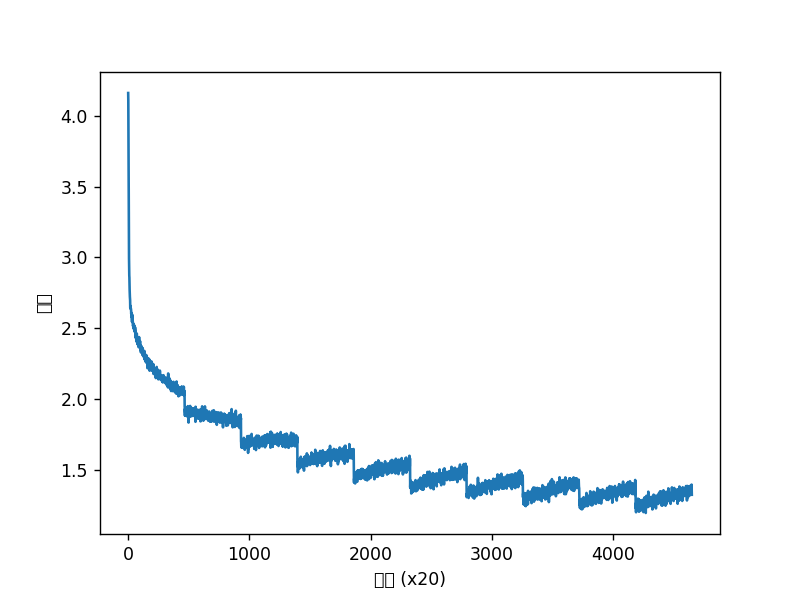

In [52]:
from common import config
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import create_contexts_target, to_cpu
from dataset import ptb
import matplotlib.pyplot as plt
%matplotlib notebook

window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus,window_size)

model = CBOW(vocab_size,hidden_size,window_size,corpus)
optimizer = Adam()
trainer = Trainer(model,optimizer)

trainer.fit(contexts, target,max_epoch,batch_size)
trainer.plot()

In [56]:
word_vecs = model.word_vec
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'CBOW_params.pkl'
with open(pkl_file,'wb') as file:
    pickle.dump(params,file,-1)

### CBOW 모델 평가하기

In [58]:
from common.util import most_similar

pkl_file = 'CBOW_params.pkl'

with open(pkl_file,'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

    querys = ['you','year','car','toyota']
    for query in querys:
        most_similar(query,word_to_id,id_to_word,word_vecs,top=5)


[query] you
 i: 0.80908203125
 we: 0.7958984375
 they: 0.70751953125
 mom: 0.60009765625
 she: 0.5908203125

[query] year
 month: 0.84814453125
 week: 0.841796875
 day: 0.751953125
 decade: 0.681640625
 quarter: 0.6796875

[query] car
 move: 0.6220703125
 plant: 0.60498046875
 decline: 0.5791015625
 share: 0.57763671875
 way: 0.5771484375

[query] toyota
 it: 0.56982421875
 nissan: 0.53955078125
 japan: 0.53759765625
 fuel: 0.53662109375
 ibm: 0.53173828125


In [59]:
# 유추문제 풀어보기
from common.util import analogy

analogy('man','king','woman',word_to_id,id_to_word,word_vecs,top=5)


[analogy] man:king = woman:?
 string: 1.947265625
 arby: 1.734375
 letter: 1.71875
 host: 1.671875
 fortune: 1.6162109375


In [60]:
analogy('king','man','queen',word_to_id,id_to_word,word_vecs,top=5)
analogy('take','took','go',word_to_id,id_to_word,word_vecs,top=5)
analogy('car','cars','child',word_to_id,id_to_word,word_vecs,top=5)
analogy('good','better','bad',word_to_id,id_to_word,word_vecs,top=5)


[analogy] king:man = queen:?
 quarter: 2.5234375
 nation: 2.20703125
 dollar: 2.146484375
 spokesman: 2.13671875
 economy: 2.08984375

[analogy] take:took = go:?
 went: 2.044921875
 inched: 2.025390625
 grains: 1.8544921875
 a.m: 1.833984375
 came: 1.798828125

[analogy] car:cars = child:?
 a.m: 3.138671875
 milestones: 3.09765625
 bond-equivalent: 2.72265625
 amounts: 2.5859375
 dozens: 2.478515625

[analogy] good:better = bad:?
 wake: 1.767578125
 durkin: 1.4921875
 bottom: 1.478515625
 vicar: 1.4482421875
 zone: 1.41796875


## word2vec 남은 숙제

### word2vec을 사용한 에플리케이션의 예